Very dumbed-down version of what they do here: "Experimental Bayesian Calibration of Trapped-Ion Entangling Operations" (https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.020350).

- Instead of a simultaneous 4D calibration, here we do 4 1D calibrations. 
- Instead of cubic-spline interpolation, we do direct sampling. 
- Instead of a variable measurement strategy that minimizes the variance of the posterior based on sensitivity to phase and Rabi frequency, we go with a constant measurement strategy. 

Original noise parameters ($\sigma_\Omega, \sigma_\Delta, \sigma_\epsilon, \sigma_\varphi$) based on the original paper (see Fig. 4)

Derivative noise parameters ($\sigma_I, \sigma_{f_{cl}}, \sigma_{\nu}$) based on **single_qubit_rotations/single_qubit_noise_sim.ipynb**.

In [1]:
# Run this cell to test if the LinearChain object is gonna give us a headache.
using IonSim

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

  7.351566 seconds (14.89 M allocations: 957.793 MiB, 9.55% gc time, 99.79% compilation time: <1% of which was recompilation)


In [1645]:
using QuantumOptics
import PyPlot
using Random, Distributions
using ProgressBars
Random.seed!(0)

include("./molmer_sorensen.jl")
using .MolmerSorensen: construct_MS_chamber
const plt = PyPlot;

using DelimitedFiles

The Molmer-Sorensen Hamiltonian: $\hat{H} = \frac{\Omega(t)}{2} \sum_{i=1,2} \Bigg[ \bigg( \hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)} \bigg) \otimes e^{i[\eta(\hat{a} e^{-i\nu t} + \hat{a}^\dagger e^{i \nu t} ) - \Delta_i t + \phi_i ) ] } \Bigg] + h.c.$

## 0. Setup

Global variables

In [1646]:
######################### Intensity #########################
μ_I = 94326.65907221894 # W/cm^2
σ_I = 38106.10236476285 # W/cm^2
Normal_I = Normal(μ_I, σ_I)

######################### Trap frequency #########################
μ_ν = 2.5e5 # Hz
σ_ν = 2e3 # Hz
Normal_ν = Normal(μ_ν, σ_ν)

######################### Center-line frequency #########################
C0 = 2.99792458e8
δλ_MAX = 1e-15
μ_f_cl = 4.111550352057269e14 # Hz
σ_f_cl = 2e3 # Hz
Normal_f_cl = Normal(μ_f_cl, σ_f_cl)

######################### Phase #########################
μ_ϕ = 0
σ_ϕ = 0.16*π
Normal_ϕ = Normal(μ_ϕ, σ_ϕ)

######################### Other chamber parameters #########################
DETUNING = 1e4 # Hz
AC_CORRECTION = 0; # Hz
B_STRENGTH = 0.0005999899999999999; # T

GATE_TIME = 1/DETUNING # seconds
T_RANGE = 0:GATE_TIME*1e-3:GATE_TIME
TIMESCALE = 1e-6 # seconds 

######################### Other global variables #########################
FID_THRESH = 1 - 1.2e-3
MAX_LOOPS = 100
N_SHOTS = 100

CALCIUM40 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
N_PARTICLES_GEN = 21
N_PARTICLES_GEN_ϕ = 25
N_PARTICLES = Int(1e4)
FINITE_RWA_CUTOFF = 1e5

# Intialize chamber object, whose properties will be updated in the loop
MS_CHAMBER_TUNED = construct_MS_chamber(
    μ_ν,
    μ_I,
    C0/μ_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_TUNED.lasers[1], 0)
phase!(MS_CHAMBER_TUNED.lasers[2], 0)

ket0_VIB_MODE = IonSim.modes(MS_CHAMBER_TUNED)[1][0] # ground state of first vibrational mode
dm0_VIB_MODE = dm(ket0_VIB_MODE)

# Computational states 
ket_00 = CALCIUM40["S"] ⊗ CALCIUM40["S"]
ket_01 = CALCIUM40["S"] ⊗ CALCIUM40["D"]
ket_10 = CALCIUM40["D"] ⊗ CALCIUM40["S"]
ket_11 = CALCIUM40["D"] ⊗ CALCIUM40["D"]
ρ_00 = dm(ket_00)
ρ_01 = dm(ket_01)
ρ_10 = dm(ket_10)
ρ_11 = dm(ket_11)

# Bell states 
ket_00_m_i11 = (ket_00 - 1im*ket_11)/√2
ket_00_p_i11 = (ket_00 + 1im*ket_11)/√2
ket_01_m_i10 = (ket_01 - 1im*ket_10)/√2
ket_01_p_i10 = (ket_01 + 1im*ket_10)/√2
ρ_00_m_i11 = dm(ket_00_m_i11)
ρ_00_p_i11 = dm(ket_00_p_i11)
ρ_01_m_i10 = dm(ket_01_m_i10)
ρ_01_p_i10 = dm(ket_01_p_i10)

ρ_TARGET = dm(ket_00_p_i11 ⊗ ket0_VIB_MODE)
ρ_TARGET_EL = ρ_00_p_i11;

Helper functions 

In [1647]:
# For loading CSV's into matrices 
function load_csv_to_matrix(fname)
    data = readdlm(fname)
    data = [split(line, ",") for line in data]
    data = [[parse(Float64, elem) for elem in row] for row in data]

    matrix = zeros((length(data), length(data[1])))
    for i in 1:length(data)
        matrix[i,:] = [elem for elem in data[i]]
    end
    return matrix
end

# For measuring ZZ
function ZZ_probs(ψf) # random projective measurement onto the computational basis
    p_00 = real(tr( (ρ_00 ⊗ dm0_VIB_MODE) * ψf))
    p_11 = real(tr( (ρ_11 ⊗ dm0_VIB_MODE) * ψf))
    p_01 = real(tr( (ρ_01 ⊗ dm0_VIB_MODE) * ψf))
    p_10 = real(tr( (ρ_10 ⊗ dm0_VIB_MODE) * ψf))

    return p_00, p_11, p_01, p_10
end

# For plotting state populations 
function plot_populations_double(chamber, tout, sol; title = Nothing)

    # compute expectation values
    prob_00 = expect(ρ_00 ⊗ dm0_VIB_MODE , sol)  # 𝔼(|S⟩|S⟩)
    prob_11 = expect(ρ_11 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|D⟩|D⟩)
    prob_01 = expect(ρ_01 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|D⟩)
    prob_10 = expect(ρ_10 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|D⟩|S⟩)
    prob_00_p_i11 = expect(ρ_00_p_i11 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|S⟩ + i|D⟩|D⟩)
    prob_00_m_i11 = expect(ρ_00_m_i11 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|S⟩ - i|D⟩|D⟩)
    prob_01_p_i10 = expect(ρ_01_p_i10 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|D⟩ + i|D⟩|S⟩)
    prob_01_m_i10 = expect(ρ_01_m_i10 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|D⟩ - i|D⟩|S⟩)

    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(tout, prob_00, label="00")
    ax1.plot(tout, prob_11, label="11")
    ax1.plot(tout, prob_01, label="01")
    ax1.plot(tout, prob_10, label="10")
    ax1.set_xlim(tout[1], tout[end])
    ax1.set_ylim(0, 1)
    ax1.legend(loc=1)
    ax1.set_xlabel("Time (μs)")
    ax1.set_ylabel("Population")
    ax1.set_title("Computational basis states")

    ax2.plot(tout, prob_00_p_i11, label="00 + i11")
    ax2.plot(tout, prob_00_m_i11, label="00 - i11")
    ax2.plot(tout, prob_01_p_i10, label="01 + i10")
    ax2.plot(tout, prob_01_m_i10, label="01 - i10")
    ax2.set_xlim(tout[1], tout[end])
    ax2.set_ylim(0, 1)
    ax2.legend(loc=1)
    ax2.set_xlabel("Time (μs)")
    ax2.set_ylabel("Population")
    ax2.set_title("Bell states")
    if title != Nothing
        fig.suptitle(title)
    end

    return fig
end

# For binning probability distributions
function bin_prior(particles, weights, n_bins)
    new_bins = zeros(n_bins)
    new_weights = zeros(n_bins)
    bin_width = (maximum(particles) - minimum(particles))/n_bins
    
    for i in 1:n_bins
        bin_start = minimum(particles) + (i-1)*bin_width
        bin_end = bin_start + bin_width
        new_bins[i] = mean([bin_start, bin_end])

        bin_filter = (particles .>= bin_start).&(particles .< bin_end)
        weight_in_bin = sum(weights[bin_filter])
        new_weights[i] = weight_in_bin
        
    end
    return new_bins, new_weights, bin_width
end

bin_prior (generic function with 1 method)

Test fidelity with optimal parameters

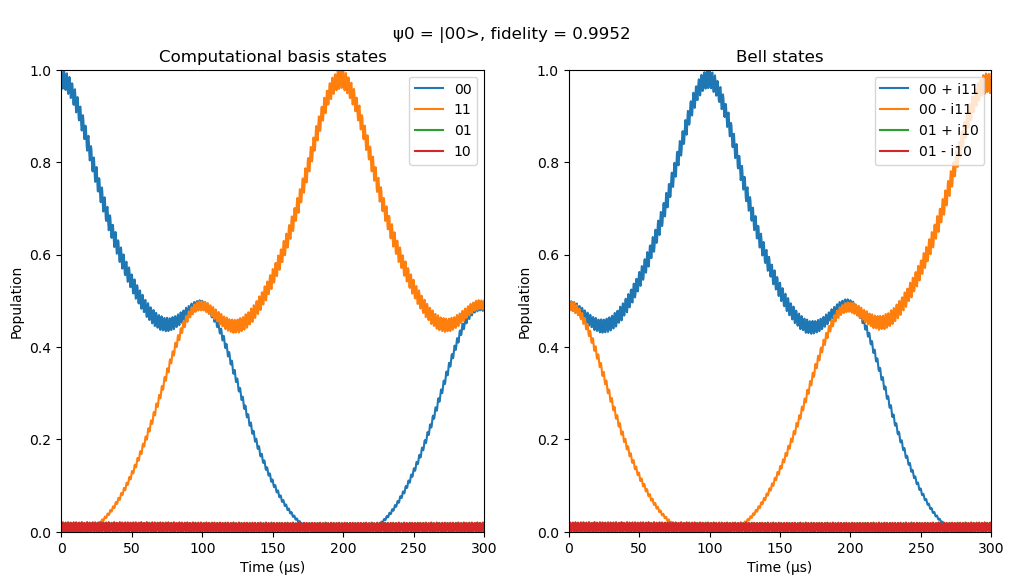

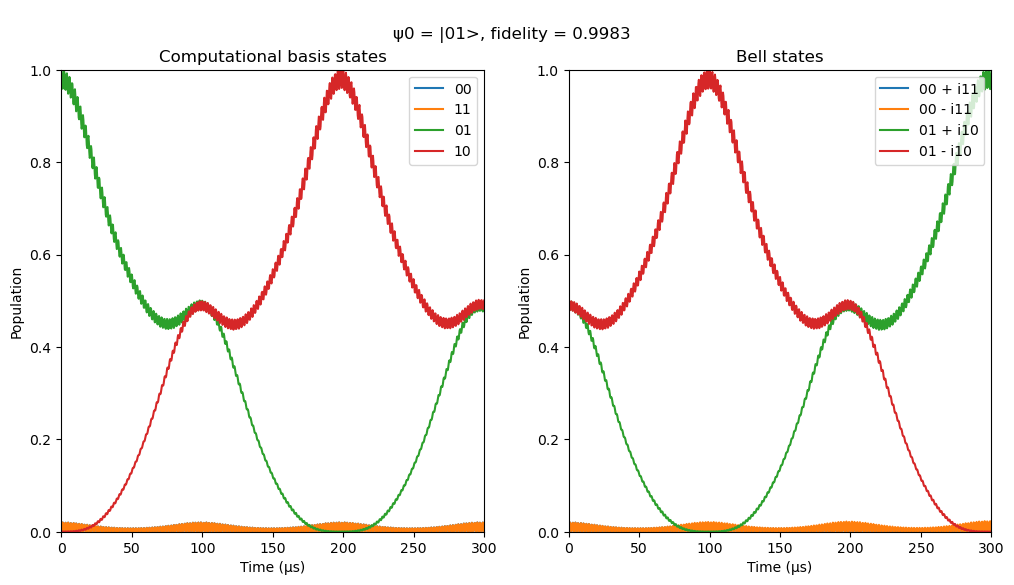

In [1648]:
h = hamiltonian(MS_CHAMBER_TUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);

@time tout00, sol00 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h);
ρ_final = ptrace(dm(sol00[end]), 3)
fid = round(real(fidelity(ρ_final, ρ_00_m_i11)), digits=4)
fig = plot_populations_double(MS_CHAMBER_TUNED, tout00, sol00)
fig.suptitle("\nψ0 = |00>, fidelity = $fid")
plt.display(fig)
plt.close(fig)

@time tout01, sol01 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_01 ⊗ ket0_VIB_MODE , h);
ρ_final = ptrace(dm(sol01[end]), 3)

fid = round(real(fidelity(ρ_final, ρ_01_p_i10)), digits=4)
fig = plot_populations_double(MS_CHAMBER_TUNED, tout01, sol01)
fig.suptitle("\nψ0 = |01>, fidelity = $fid")
plt.display(fig)
plt.close(fig)


Functions to update true parameters, given measured parameters

1. Intensity
$\kappa = \frac{I}{\Omega^2} \Longrightarrow \Omega^2 = \frac{I}{\kappa} \Longrightarrow \Omega = \sqrt{\frac{I}{\kappa}}$

    $\frac{\Omega_{\text{opt}}}{\overline{\Omega}} = \frac{\sqrt{I_{\text{opt}}/\kappa}}{\sqrt{\overline{I}/\kappa}} = \sqrt{\frac{I_{\text{opt}}}{\overline{I}}}$

    In the text, they update: $t_g \to t_g \frac{\Omega_{\text{opt}}}{\overline{\Omega}}$

    Since $t_g \sim I$, here we will update: $\boxed{I \to I \sqrt{\frac{I_{\text{opt}}}{\overline{I}}}}$

2. Center-line frequency

    In the text, they update: $f_{\text{cl}} \to f_{\text{cl}} - (  \overline{\omega}_{\text{cl}} - \omega_{\text{cl, opt}} )$. 

    **Mind the confusing notation**: here, $\omega_{\text{cl}}$ is not an angular frequency, they just use $\omega$ to denote the center-line *detuning* as opposed to the center-line frequency. With this in mind, it's clear that $\overline{\omega}_{\text{cl}} - \omega_{\text{cl, opt}}$ is exactly equivalent to $ \overline{f}_{\text{cl}} - f_{\text{cl, opt}}$. 

    So we will update: $\boxed{f_{\text{cl}} \to f_{\text{cl}} - ( \overline{f}_{\text{cl}} - f_{\text{cl, opt}} )}$

3. Trap-frequency

    In the text, they update: $f_{\text{sb}} \to f_{\text{sb}} - ( \overline{\delta} - \delta_{\text{opt}})$

    So, once again, we simply update: $\boxed{\nu \to \nu - (\overline{\nu} - \nu_{\text{opt}})}$

4. Phase
    $\boxed{\varphi \to \varphi - (\overline{\Delta \varphi} - \Delta \varphi_{\text{opt}})}$

In [1649]:
# Intensity
function compute_I_new(chamber, I_bar)
    I = chamber.lasers[1].I(0)
    return I*sqrt(μ_I/I_bar)
end

function update_intensity(chamber, I_new)
    intensity!(chamber.lasers[1], I_new)
    intensity!(chamber.lasers[2], I_new)
end

# Center-line frequency 
function compute_f_cl_new(chamber, f_cl_bar)
    λ_cl = chamber.lasers[1].λ
    f_cl = C0/λ_cl
    return f_cl - (f_cl_bar - μ_f_cl)
end

function update_f_cl(chamber, f_cl_new)
    wavelength!(chamber.lasers[1], C0/f_cl_new)
    wavelength!(chamber.lasers[2], C0/f_cl_new)
end

# Trap-frequency
function compute_ν_new(chamber, ν_bar)
    ν = chamber.iontrap.comfrequencies.z
    return ν - (ν_bar - μ_ν)
end

function update_ν(chamber, ν_new)
    # Can't update the trap-frequency in-place
    # Must create a brand new chamber, with all the same properties except for the trap frequency
    I = chamber.lasers[1].I(0)
    λ_cl = chamber.lasers[1].λ
    chamber_new = construct_MS_chamber(
        ν_new,
        I,
        λ_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )

    # Recall: The detuning is based on the *target* trap-frequency
    chamber.lasers[1].Δ = μ_ν + DETUNING - AC_CORRECTION
    chamber.lasers[2].Δ = -(μ_ν + DETUNING - AC_CORRECTION)
    return chamber_new
end 

# Phase
function compute_ϕ_new(chamber, ϕ_bar)
    ϕ = chamber.lasers[2].ϕ(0)
    return ϕ - (ϕ_bar - μ_ϕ)
end

function update_ϕ(chamber, ϕ_new)
    phase!(chamber.lasers[2], ϕ_new)
end
 

update_ϕ (generic function with 1 method)

# 1. Precompute conditional probability densities

## 1.a. Define our measurement protocol $m$

"We restrict our considerations to sequences of MS gates without any local operations. Besides the number of gates $N_g$ we can also intentionally introduce a phase difference $\Delta \varphi_{\text{target}}$ between the gates. We restrict the phase difference settings to either $\Delta \varphi_{\text{target}} = 0$ or $\Delta \varphi_{\text{target}} = \pm \pi/4$, corresponding to either consecutive $U_{\text{MS}}^0 (\pi/2)$ gates or a sequence of $U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^{\pm \pi/4} (\pi/2) ... U_{\text{MS}}^{\pm (N_g-1)\pi/4} (\pi/2) $ gates. We choose these two types of sequences as they change which parameters the sequence is most sensitive to (Fig. 6)."

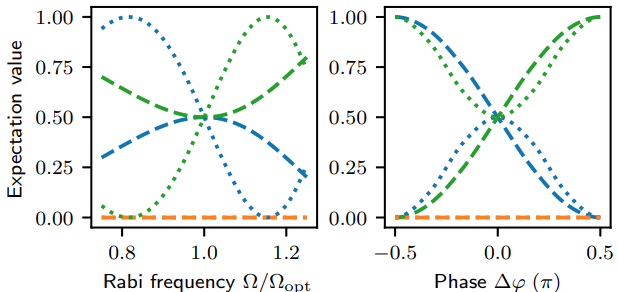

"FIG. 6. Expected outcome probabilities of $P(\ket{|g, g})$ (green), $P(\ket{|e, e})$  (blue), and $P(\ket{|e, g})  + P(\ket{|g, e})$ (orange) for a 3 $U_{\text{MS}}^0 (\pi/2)$ gate sequence (dotted) and for a $ U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^{\pi/4} (\pi/2) $ sequence (dashed). The first gate sequence is first-order insensitive to phase miscalibrations as the local minimum of the outcome probabilities around zero leads to only small variations in the likelihood of possible outcomes, and its symmetry around zero does not allow one to discriminate the sign of the miscalibration. Similar arguments can be used to see that this sequence is first-order sensitive to Rabi frequency miscalibrations. For the second gate sequence, the relation is inverted, being sensitive to phase miscalibrations at the cost of first-order insensitivity to the Rabi frequency. The qualitative behavior of the sensitivity of the center line matches the sensitivity of the phase difference, while the behavior of the sideband detuning matches the Rabi frequency."

Since we're not varying phase right now, let's stick with the first sequence of gates:
$N_g = 3 \Longrightarrow \boxed{m = U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^0 (\pi/2)} = U_{\text{MS}}^0 (3\pi/2)$

**TODO**: Consider a weighted-combination of Rabi-sensitive and phase-sensitive gates

**TODO**: Consider 50-50 split of $\psi_{\text{target}} = \frac{1}{\sqrt{2}} \left(\ket{00} + i\ket{11}\right)$ and $\psi_{\text{target}} = \frac{1}{\sqrt{2}} \left(\ket{01} + i\ket{10}\right)$ (or something else since this assumes perfect preparation of the initial state?)

## 1.b. Compute $P(m|\widetilde{\Theta}^{(i)})$ by sampling $\texttt{particles\_X}$ and numerically integrating at that point.

**TODO:** Introduce depolarizing noise to account for SPAM error.

There are two ways to *obtain* these $P(m|\widetilde{\Theta}^{(i)})$:
1. Numerical simulation at each discrete sample point.
2. Numerical simulation of an equally-spaced grid, then interpolation. 

In the paper, they go with the later because it's computationally cheaper. 

Here, we will go with the former because it's simpler and we are only calibrating one parameter.

Initialize the prior distributions

In [1650]:
# Intensity
particles_I = []
weights_I = []
n_collected_I = 0
while n_collected_I < N_PARTICLES
    I_new = rand(Normal_I)[1]
    if (I_new<0)
        continue
    end
    append!(particles_I, I_new)
    append!(weights_I, 1.0)
    n_collected_I += 1
end
weights_I = weights_I ./ sum(weights_I);
weights_I_initial = deepcopy(weights_I);
particles_I_initial = deepcopy(particles_I);

# Center-line frequency
particles_f_cl = []
weights_f_cl = []
n_collected_f_cl = 0
while n_collected_f_cl < N_PARTICLES
    f_cl_new = rand(Normal_f_cl)[1]
    λ_cl_new = C0/f_cl_new
    δλ_cl_new = abs(C0/μ_f_cl - λ_cl_new)
    if δλ_cl_new > δλ_MAX
        continue
    end
    append!(particles_f_cl, f_cl_new)
    append!(weights_f_cl, 1.0)
    n_collected_f_cl += 1
end
weights_f_cl = weights_f_cl ./ sum(weights_f_cl);
weights_f_cl_initial = deepcopy(weights_f_cl);
particles_f_cl_initial = deepcopy(particles_f_cl);

# Trap frequency
particles_ν = rand(Normal_ν, N_PARTICLES)
weights_ν = ones(N_PARTICLES)
weights_ν = weights_ν ./ sum(weights_ν);
weights_ν_initial = deepcopy(weights_ν);
particles_ν_initial = deepcopy(particles_ν);

# Phase
particles_ϕ = rand(Normal_ϕ, N_PARTICLES)
weights_ϕ = ones(N_PARTICLES)
weights_ϕ = weights_ϕ ./ sum(weights_ϕ);
weights_ϕ_initial = deepcopy(weights_ϕ);
particles_ϕ_initial = deepcopy(particles_ϕ);

Load/compute the conditional distributions

In [1651]:
function compute_sparse_probs(x_values, param_name)
    if param_name == "I"
        update_param = update_intensity
    elseif param_name == "f_cl"
        update_param = update_f_cl
    elseif param_name == "ν"
        update_param = update_ν
    elseif param_name == "ϕ"
        update_param = update_ϕ
    end

    chamber = construct_MS_chamber(
        μ_ν,
        μ_I,
        C0/μ_f_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )
    phase!(chamber.lasers[1], 0)
    phase!(chamber.lasers[2], μ_ϕ)
    
    p_m_given_x_sparse = zeros(length(x_values), 4)
    for i in 1:length(x_values)
        x = x_values[i]
        if param_name == "ν"
            chamber = update_param(chamber, x)
        else
            update_param(chamber, x)
        end
        h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
        ρ_final = dm(sol[end])
        probs = ZZ_probs(ρ_final)
        probs = probs ./ sum(probs)
        p_m_given_x_sparse[i, :] = [p for p in probs]
    end
    return p_m_given_x_sparse
end

function linear_interpolation(x, x0, x1, y0, y1)
    slope = (y1 - y0)./(x1 - x0)
    return y0 + (x - x0).*slope
end

function interpolate_dense_probabilities(particles_sparse, particles_dense, probs_sparse)
    probs_dense = zeros(length(particles_dense), 4)
    for i in 1:length(particles_dense)
        x_i = particles_dense[i]

        if sum(particles_sparse .== x_i) > 0 # If we don't need to interpolate
            idx = argmin(abs.(particles_sparse .- x_i))
            probs_dense[i,:] = probs_sparse[idx,:]
        elseif (x_i < minimum(particles_sparse)) | (x_i > maximum(particles_sparse)) # If it's out of bounds
            error("x is out of bounds of the interpolation grid!")
        else # Otherwise normal linear interpolation
            closest_left_index = findlast(particles_sparse .<= x_i)
            closest_right_index = findfirst(particles_sparse .>= x_i)
            x0 = particles_sparse[closest_left_index]
            x1 = particles_sparse[closest_right_index]
            y0 = probs_sparse[closest_left_index, :]
            y1 = probs_sparse[closest_right_index, :]
            probs_dense[i,:] = linear_interpolation(x_i, x0, x1, y0, y1)
        end
    end
            
    return probs_dense
end

interpolate_dense_probabilities (generic function with 1 method)

In [1652]:
CONDITIONAL_DISTRIBUTIONS_COMPUTED = true

true

In [1653]:
#################### Compute or load the conditional distributions ####################

if CONDITIONAL_DISTRIBUTIONS_COMPUTED
    p_m_given_I = load_csv_to_matrix("conditional_probs/interpolated/p_m_given_I_$(N_PARTICLES)_Upi2.csv")
    p_m_given_f_cl = load_csv_to_matrix("conditional_probs/interpolated/p_m_given_f_cl_$(N_PARTICLES)_Upi2.csv")
    p_m_given_ν = load_csv_to_matrix("conditional_probs/interpolated/p_m_given_ν_$(N_PARTICLES)_Upi2.csv")
    p_m_given_ϕ = load_csv_to_matrix("conditional_probs/interpolated/p_m_given_ϕ_$(N_PARTICLES)_Upi2.csv")
else
    print("Computing conditional distributions...")
    flush(stdout)

    ################### Intensity ###################
    print("\nI...")
    flush(stdout)

    I_min = minimum(particles_I)
    I_max = maximum(particles_I)
    sparse_I_step = (I_max - I_min)/(N_PARTICLES_GEN - 1)
    particles_I_sparse = I_min:sparse_I_step:I_max
    p_m_given_I_sparse = compute_sparse_probs(particles_I_sparse, "I")

    # We get the zero-intensity probabilities for free
    particles_I_sparse = vcat(0, particles_I_sparse)
    p_m_given_I_sparse = vcat(transpose([1, 0, 0, 0]), p_m_given_I_sparse)

    p_m_given_I = interpolate_dense_probabilities(particles_I_sparse, particles_I, p_m_given_I_sparse)
    writedlm("conditional_probs/interpolated/p_m_given_I_$(N_PARTICLES)_Upi2.csv",  p_m_given_I, ',')

    ################### Center-line frequency ###################
    print("\nf_cl...")
    flush(stdout)

    f_cl_min = minimum(particles_f_cl)
    f_cl_max = maximum(particles_f_cl)
    sparse_f_cl_step = (f_cl_max - f_cl_min)/(N_PARTICLES_GEN - 1)
    particles_f_cl_sparse = f_cl_min:sparse_f_cl_step:f_cl_max
    p_m_given_f_cl_sparse = compute_sparse_probs(particles_f_cl_sparse, "f_cl")
    p_m_given_f_cl = interpolate_dense_probabilities(particles_f_cl_sparse, particles_f_cl, p_m_given_f_cl_sparse)

    writedlm("conditional_probs/interpolated/p_m_given_f_cl_$(N_PARTICLES)_Upi2.csv",  p_m_given_f_cl, ',')

    ################### Trap frequency ###################
    print("\nν...")
    flush(stdout)

    ν_min = minimum(particles_ν)
    ν_max = maximum(particles_ν)
    sparse_ν_step = (ν_max - ν_min)/(N_PARTICLES_GEN - 1)
    particles_ν_sparse = ν_min:sparse_ν_step:ν_max
    p_m_given_ν_sparse = compute_sparse_probs(particles_ν_sparse, "ν")
    p_m_given_ν = interpolate_dense_probabilities(particles_ν_sparse, particles_ν, p_m_given_ν_sparse)

    writedlm("conditional_probs/interpolated/p_m_given_ν_$(N_PARTICLES)_Upi2.csv",  p_m_given_ν, ',')

    ################### Phase ###################
    print("\nϕ...")
    flush(stdout)

    ϕ_min = μ_ϕ - π
    ϕ_max = μ_ϕ + π
    sparse_ϕ_step = (ϕ_max - ϕ_min)/(N_PARTICLES_GEN_ϕ - 1)
    particles_ϕ_sparse = ϕ_min:sparse_ϕ_step:ϕ_max
    p_m_given_ϕ_sparse = compute_sparse_probs(particles_ϕ_sparse, "ϕ")
    p_m_given_ϕ = interpolate_dense_probabilities(particles_ϕ_sparse, particles_ϕ, p_m_given_ϕ_sparse)

    writedlm("conditional_probs/interpolated/p_m_given_ϕ_$(N_PARTICLES)_Upi2.csv",  p_m_given_ϕ, ',')
    
    CONDITIONAL_DISTRIBUTIONS_COMPUTED = true
    
end;

# 2. Calibrating: Intensity

**Paper**: "The Bayesian inference requires an initial prior (i.e. $P(\Theta)$), and we must choose an initial set of particles to represent this prior. We choose a known continuous probability density function as prior."

**Here**: $\Theta = (I) \Longrightarrow P(\Theta) \sim \mathcal{N}(\mu_I, \sigma_I) \Longrightarrow \boxed{P(\Theta) = \frac{1}{\sqrt{2\pi \sigma_I}} \exp\left[-\frac{1}{2}  \frac{(i - \mu_I)^2}{\sigma_I^2} \right]}  $

**Paper**: "We can then initialize the particle filter from that probability function by randomly sampling $N_p$ times from the distribution and setting all the weights to $1/N_p$."

**Here**: the $\texttt{weights\_I}$ distribution is what gets updated throughout the calibration process. At each sample point $\widetilde{\Theta}^{(i)} \in \texttt{particles\_I}$, the relevant weight $w^{(i)} \in \texttt{weights\_I}$ is updated according to $w_m^{(i)} \propto P(m|\widetilde{\Theta}^{(i)}) w^{(i)}$.

Helper functions for calibration:

In [1654]:
function LiuWestResampling(particles, weights, h, measurements, conditional_dist)
    N = length(particles)
    xbar = sum(weights .* particles)
    var = (1/(N-1))*sum(weights .* ((particles .- xbar).^2))

    a = sqrt(1-h^2)
    new_particles = zeros(N)
    new_weights = zeros(N)
    for i in 1:N
        m = a*particles[i] + (1-a)*xbar
        S = var*(h^2)
        new_particle = rand(Normal(m, sqrt(S)))

        likelihood = calculate_likelihood(new_particle, particles, measurements, conditional_dist)
        new_weight = likelihood*weights[i]

        new_particles[i] = new_particle
        new_weights[i] = new_weight
    end
    new_weights = new_weights ./ sum(new_weights)

    ###### Resampling ######
    for i in 1:N
        rand_idx = rand(Categorical(new_weights))
        weights[i] = new_weights[rand_idx]
        particles[i] = new_particles[rand_idx]
    end
    weights = weights ./ sum(weights)
    
    return particles, weights
end

function calculate_likelihood(particle, particles, measurements, conditional_dist)
    closest_particle_idx = argmin(abs.(particles .- particle))
    conditional_dist_i = conditional_dist[closest_particle_idx, :]
    p_particle_given_measurements = mean(conditional_dist_i[measurements])
    return p_particle_given_measurements
end

function get_I(chamber)
    return chamber.lasers[1].I(0)
end

function get_f_cl(chamber)
    return C0/chamber.lasers[1].λ
end

function get_ν(chamber)
    return chamber.iontrap.comfrequencies.z
end

function get_ϕ(chamber)
    return chamber.lasers[2].ϕ(0)
end

get_ϕ (generic function with 1 method)

Top-level calibration function:

In [1659]:
function BayesianCalibration1D(chamber, particles, weights, conditional_dist,
                            param_name, resample_freq, resample_h; 
                            n_shots = 100, max_iter = 100, fidelity_threshold = 1 - 1.2e-3)
    
    # Get functions to access and update parameter
    if param_name == "I"
        get_param = get_I
        compute_new_param_value = compute_I_new
        update_param = update_intensity
    elseif param_name == "f_cl"
        get_param = get_f_cl
        compute_new_param_value = compute_f_cl_new
        update_param = update_f_cl
    elseif param_name == "ν"
        get_param = get_ν
        compute_new_param_value = compute_ν_new
        update_param = update_ν
    elseif param_name == "ϕ"
        get_param = get_ϕ
        compute_new_param_value = compute_ϕ_new
        update_param = update_ϕ
    else
        error("Invalid parameter name")
    end

    # To track parameter value
    x = get_param(chamber)
    x_tracker = [x]

    # To track belief about parameter value
    xbar = sum(weights .* particles)
    xbar_tracker = [xbar]

    # To track fidelity
    h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
    ρ = dm(sol[end])
    ρ_el = ptrace(ρ, 3)
    fid = real(fidelity(ρ, ρ_TARGET))
    fid_el = real(fidelity(ρ_el, ρ_TARGET_EL))
    fid_tracker = []
    fid_el_tracker = []

    # To track electronic-motional entanglement entropy
    ee_tracker = []
    
    # Begin Bayesian calibration
    iter = 0
    while fid < fidelity_threshold
        iter += 1
        if iter > max_iter
            break
        end
    
        # Perform measurements 
        h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
        ρ = dm(sol[end])
        ρ_el = ptrace(ρ, 3)
        probs = ZZ_probs(ρ)
        probs = probs ./ sum(probs)
        m_t = rand(Categorical([p for p in probs]), n_shots)

        # Resample
        if iter%Int(resample_freq) == 0
            particles, weights = LiuWestResampling(particles, weights, resample_h, m_t, conditional_dist)
        end

        # Update beliefs
        for i in 1:length(particles)
            w_i = weights[i]
            theta_i = particles[i]
            p_m_given_x_dist = conditional_dist[i,:]
            p_m_given_x = mean(p_m_given_x_dist[m_t])
            weights[i] = w_i*p_m_given_x
        end
        weights = weights ./ sum(weights)
        xbar = sum(weights .* particles)

        # Update parameter
        if param_name == "ϕ"
            x = compute_new_param_value(chamber, xbar)%2π
        else
            x = compute_new_param_value(chamber, xbar)
        end

        if param_name == "f_cl"
            λ_cl_new = C0/x
            δλ_cl_new = abs(C0/μ_f_cl - λ_cl_new)
            if δλ_cl_new > δλ_MAX
                print("Runaway into non-integrable region")
                flush(stdout)
                break
            end
        end
        
        if param_name == "ν"
            chamber = update_param(chamber, x)
        else  
            update_param(chamber, x)
        end

        # Track values of interest
        append!(x_tracker, x)
        append!(xbar_tracker, xbar)
        append!(fid_tracker, real(fidelity(ρ, ρ_TARGET)))
        append!(fid_el_tracker, real(fidelity(ρ_el, ρ_TARGET_EL)))
        append!(ee_tracker, entropy_vn(ρ_el))
        fid = fid_tracker[end]
    end 

    # These values were never actually used to compute the fidelity, so we'll remove them
    pop!(x_tracker)
    pop!(xbar_tracker)
    
    return chamber, particles, weights, x_tracker, xbar_tracker, fid_tracker, fid_el_tracker, ee_tracker

end

BayesianCalibration1D (generic function with 1 method)

## 2.a. Initialize in uncalibrated state

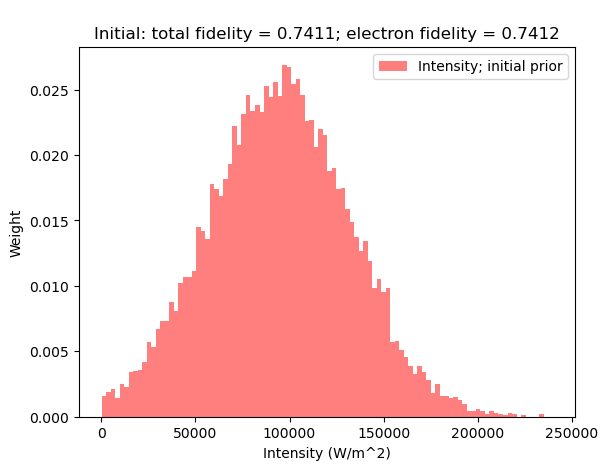

In [1656]:
Random.seed!(1)

# Reinitialize the prior
weights_I = deepcopy(weights_I_initial);
particles_I = deepcopy(particles_I_initial);

# Initial theta
# I_INITIAL = + 3*σ_I
I_INITIAL = 2*μ_I
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    μ_ν,
    I_INITIAL,
    C0/μ_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], μ_ϕ)
phase!(MS_CHAMBER_UNTUNED.lasers[2], μ_ϕ)

# Initial belief about theta
I_bar = sum(particles_I .* weights_I)

# Initial fidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = dm(sol[end])
ρ_el = ptrace(ρ, 3)
fid = real(fidelity(ρ, ρ_TARGET))
fid_el = real(fidelity(ρ_el, ρ_TARGET_EL))

particles_I_binned_initial, weights_I_binned_initial, binwidth_I_initial = bin_prior(particles_I_initial, weights_I_initial, 100)
fig = plt.figure()
plt.bar(particles_I_binned_initial, weights_I_binned_initial, width = binwidth_I_initial, color="r", label = "Intensity; initial prior", alpha=0.5)
plt.title("\nInitial: total fidelity = $(round(fid, digits=4)); electron fidelity = $(round(fid_el, digits=4))")
plt.xlabel("Intensity (W/m^2)")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)


## 2.b. Calibrate

In [1657]:
MS_CHAMBER_I_TUNED, particles_I, weights_I, I_tracker, I_bar_tracker, I_fid_tracker, I_fid_el_tracker, I_ee_tracker = BayesianCalibration1D(MS_CHAMBER_UNTUNED, particles_I, weights_I, p_m_given_I, "I", 10, 0.1)
length(I_tracker)

200

## 2.c. Analyze results

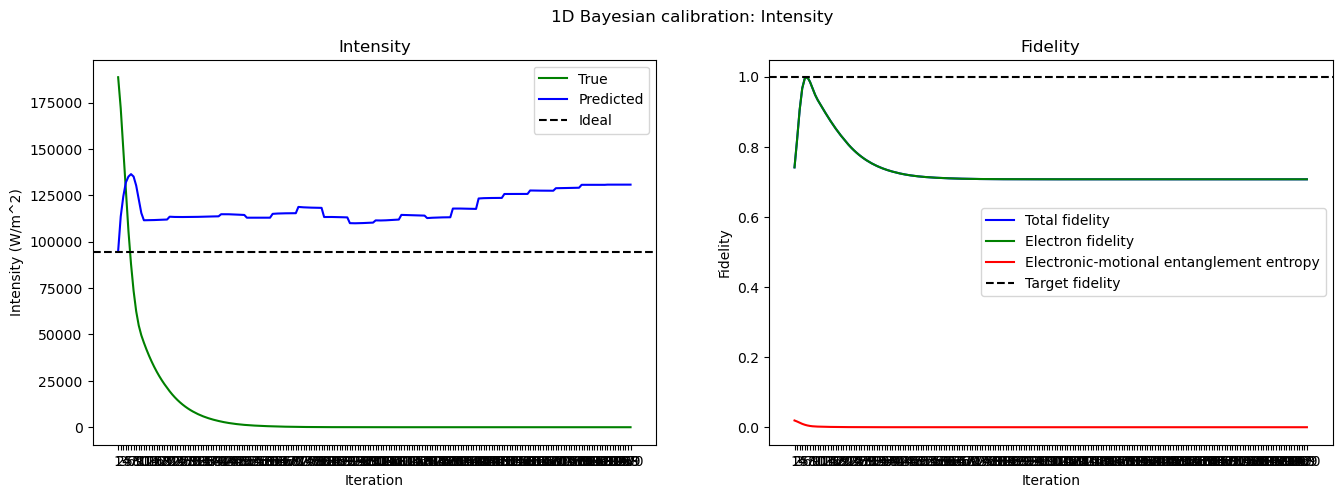

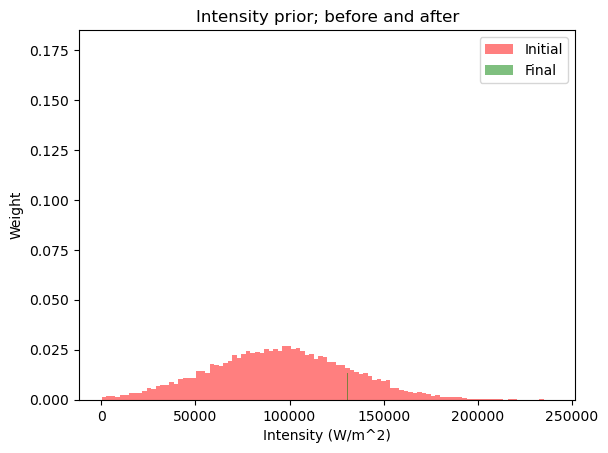

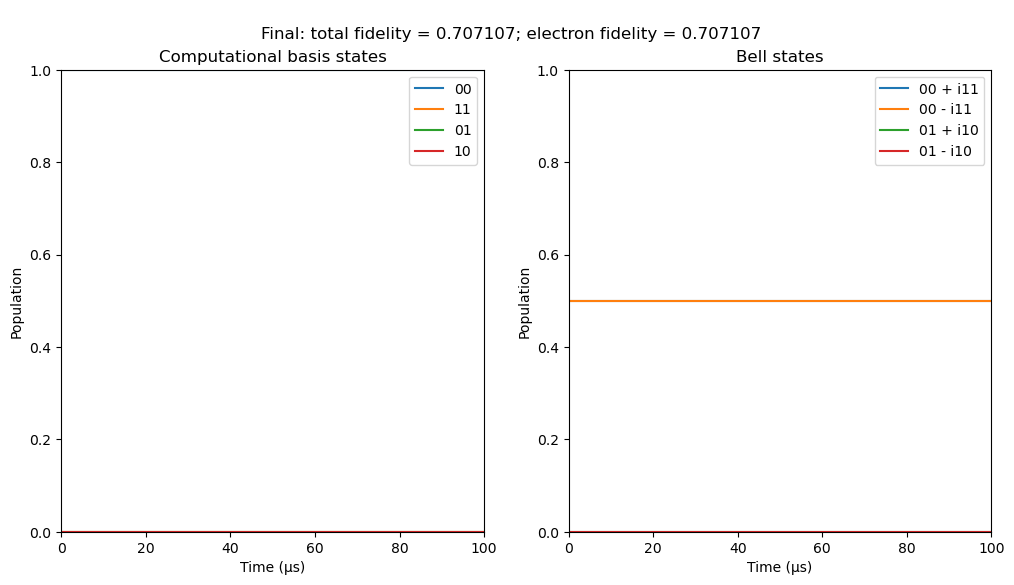

In [1658]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(1:length(I_tracker), I_tracker, color="g", label = "True")
ax1.plot(1:length(I_bar_tracker), I_bar_tracker, color="b", label = "Predicted")
ax1.axhline(μ_I, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=1:length(I_tracker))
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Intensity (W/m^2)")
ax1.set_title("Intensity")
ax1.legend()
ax2.plot(1:length(I_fid_tracker), I_fid_tracker, color="b", label = "Total fidelity")
ax2.plot(1:length(I_fid_el_tracker), I_fid_el_tracker, color="g", label = "Electron fidelity")
ax2.plot(1:length(I_ee_tracker), I_ee_tracker, color="r", label = "Electronic-motional entanglement entropy")
ax2.axhline(FID_THRESH, label = "Target fidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=1:length(I_fid_tracker))
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Fidelity")
ax2.set_title("Fidelity")
ax2.legend()
fig.suptitle("1D Bayesian calibration: Intensity")
plt.display(fig)
plt.close(fig)

particles_I_binned_final, weights_I_binned_final, binwidth_I_final = bin_prior(particles_I, weights_I, 100)
fig = plt.figure()
plt.bar(particles_I_binned_initial, weights_I_binned_initial, width = binwidth_I_initial, color="r", label = "Initial", alpha=0.5)
plt.bar(particles_I_binned_final, weights_I_binned_final, width = binwidth_I_final, color="g", label = "Final", alpha=0.5)
plt.title("Intensity prior; before and after")
plt.xlabel("Intensity (W/m^2)")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)

h = hamiltonian(MS_CHAMBER_I_TUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = dm(sol[end])
fid = real(fidelity(ρ, ρ_TARGET))
ρ_el = ptrace(ρ, 3)
fid_el = real(fidelity(ρ_el, ρ_00_p_i11))
fig = plot_populations_double(MS_CHAMBER_I_TUNED, tout, sol)
plt.suptitle("\nFinal: total fidelity = $(round(fid, digits=6)); electron fidelity = $(round(fid_el, digits=6))")
plt.display(fig)
plt.close(fig)

**IMPORTANT TODO:** Investigate runaway effect when $\texttt{I\_initial} < \texttt{INTENSITY\_MS}$ and $\texttt{1 - FID\_THRESH}$ is too small; recall Lukas: "the way you do the sampling is tricky, but important"

# 3. Calibrating: Center-line frequency

## 3.a. Initialize in uncalibrated state

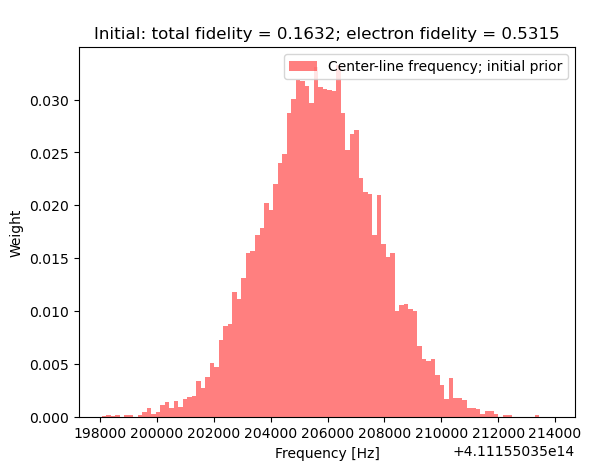

In [1660]:
Random.seed!(1)

# Reinitialize the prior
weights_f_cl = deepcopy(weights_f_cl_initial);
particles_f_cl = deepcopy(particles_f_cl_initial);

# Initial theta
# F_CL_INITIAL = μ_f_cl + 3*σ_f_cl
# λ_CL_INITIAL = C0/F_CL_INITIAL

λ_CL_INITIAL = C0/μ_f_cl + δλ_MAX*1e-2
F_CL_INITIAL = C0/λ_CL_INITIAL

MS_CHAMBER_UNTUNED = construct_MS_chamber(
    μ_ν,
    μ_I,
    C0/F_CL_INITIAL,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], μ_ϕ)
phase!(MS_CHAMBER_UNTUNED.lasers[2], μ_ϕ)

# Initial belief about theta
f_cl_bar = sum(particles_f_cl .* weights_f_cl)

# Initial fidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = dm(sol[end])
ρ_el = ptrace(ρ, 3)
fid = real(fidelity(ρ, ρ_TARGET))
fid_el = real(fidelity(ρ_el, ρ_00_m_i11))

particles_f_cl_binned_initial, weights_f_cl_binned_initial, binwidth_f_cl_initial = bin_prior(particles_f_cl_initial, weights_f_cl_initial, 100)
fig = plt.figure()
plt.bar(particles_f_cl_binned_initial, weights_f_cl_binned_initial, width = binwidth_f_cl_initial, color="r", label = "Center-line frequency; initial prior", alpha=0.5)
plt.title("\nInitial: total fidelity = $(round(fid, digits=4)); electron fidelity = $(round(fid_el, digits=4))")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)

## 3.b. Calibrate

In [1661]:
MS_CHAMBER_f_cl_TUNED, particles_f_cl, weights_f_cl, f_cl_tracker, f_cl_bar_tracker, f_cl_fid_tracker, f_cl_fid_el_tracker, f_cl_ee_tracker = BayesianCalibration1D(MS_CHAMBER_UNTUNED, particles_f_cl, weights_f_cl, p_m_given_f_cl, "f_cl", 2, 0.1)
length(f_cl_tracker)

100

## 3.c. Analyze results

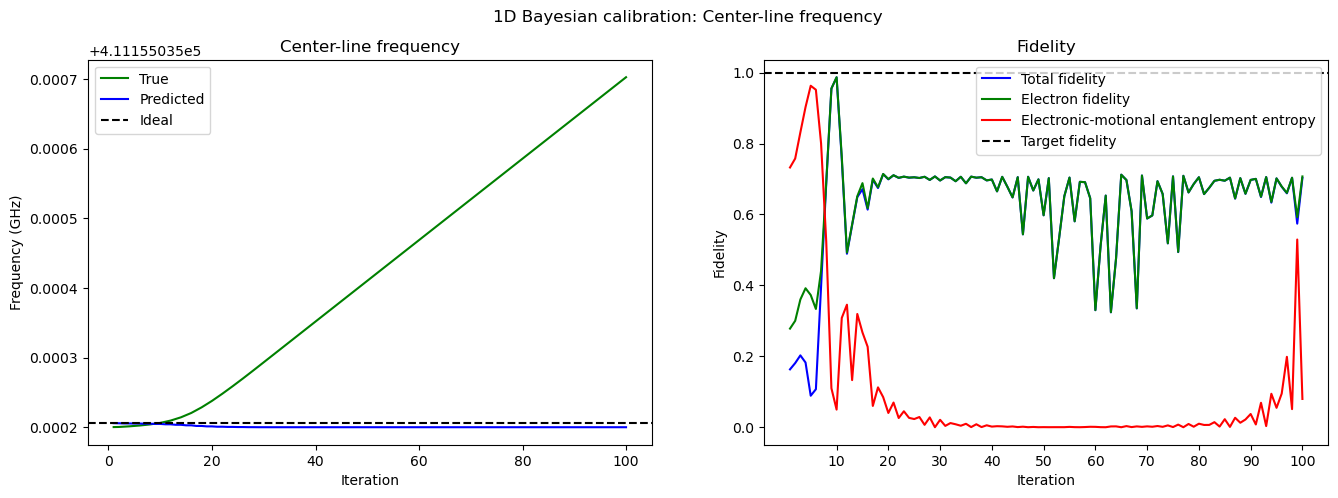

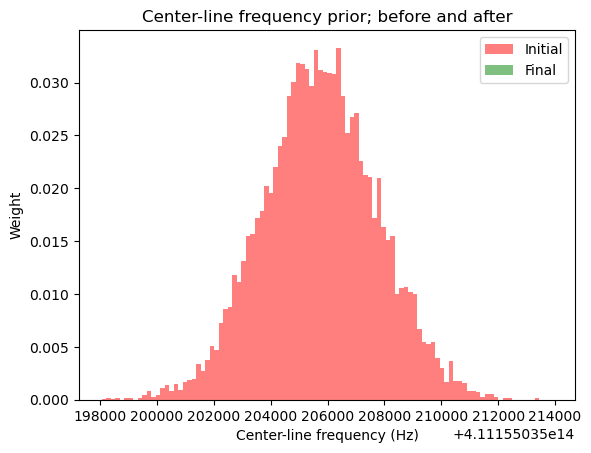

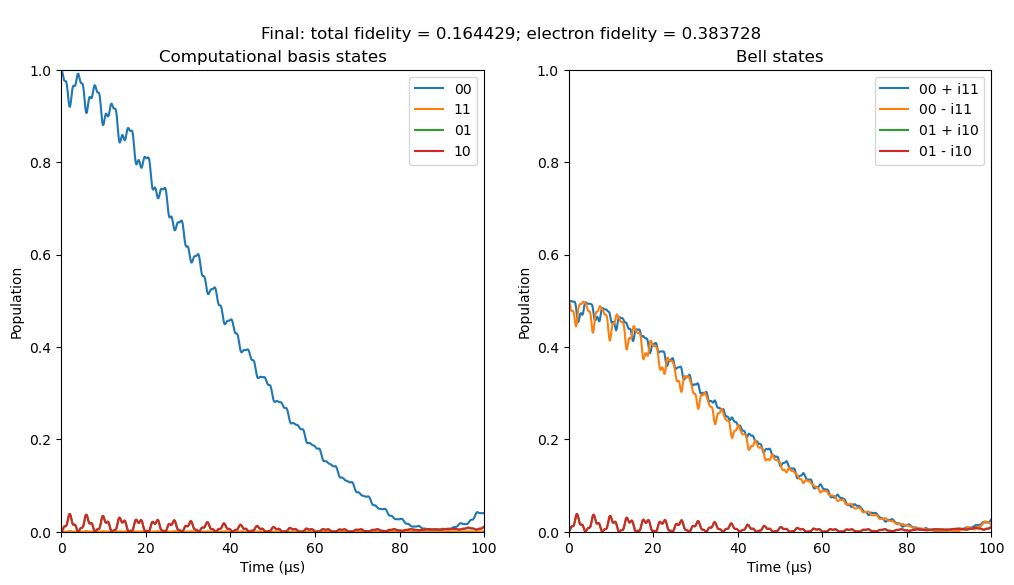

In [1662]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(1:length(f_cl_tracker), f_cl_tracker*1e-9, color="g", label = "True")
ax1.plot(1:length(f_cl_bar_tracker), f_cl_bar_tracker*1e-9, color="b", label = "Predicted")
ax1.axhline(μ_f_cl*1e-9, color="k", linestyle="--", label = "Ideal")
ax2.set_xticks(ticks=[i for i in 1:length(f_cl_tracker) if i%10==0])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Frequency (GHz)")
ax1.set_title("Center-line frequency")
ax1.legend()
ax2.plot(1:length(f_cl_fid_tracker), f_cl_fid_tracker, color="b", label="Total fidelity")
ax2.plot(1:length(f_cl_fid_el_tracker), f_cl_fid_el_tracker, color="g", label="Electron fidelity")
ax2.plot(1:length(f_cl_ee_tracker), f_cl_ee_tracker, color="r", label = "Electronic-motional entanglement entropy")
ax2.axhline(FID_THRESH, label = "Target fidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=[i for i in 1:length(f_cl_fid_tracker) if i%10==0])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Fidelity")
ax2.set_title("Fidelity")
ax2.legend()
fig.suptitle("1D Bayesian calibration: Center-line frequency")
plt.display(fig)
plt.close(fig)

particles_f_cl_binned_final, weights_f_cl_binned_final, binwidth_f_cl_final = bin_prior(particles_f_cl, weights_f_cl, 100)
fig = plt.figure()
plt.bar(particles_f_cl_binned_initial, weights_f_cl_binned_initial, width = binwidth_f_cl_initial, color="r", label = "Initial", alpha=0.5)
plt.bar(particles_f_cl_binned_final, weights_f_cl_binned_final, width = binwidth_f_cl_final, color="g", label = "Final", alpha=0.5)
plt.title("Center-line frequency prior; before and after")
plt.xlabel("Center-line frequency (Hz)")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)

h = hamiltonian(MS_CHAMBER_f_cl_TUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = dm(sol[end])
fid = real(fidelity(ρ, ρ_TARGET))
ρ_el = ptrace(ρ, 3)
fid_el = real(fidelity(ρ_el, ρ_00_p_i11))
fig = plot_populations_double(MS_CHAMBER_f_cl_TUNED, tout, sol)
plt.suptitle("\nFinal: total fidelity = $(round(fid, digits=6)); electron fidelity = $(round(fid_el, digits=6))")
plt.display(fig)
plt.close(fig)

**NOTE:** Sometimes it performs better using $\texttt{FINITE\_RWA\_CUTOFF = 5}$ rather than $\texttt{Inf}$

# 4. Calibrating: Trap frequency

## 4.a. Initialize in uncalibrated state

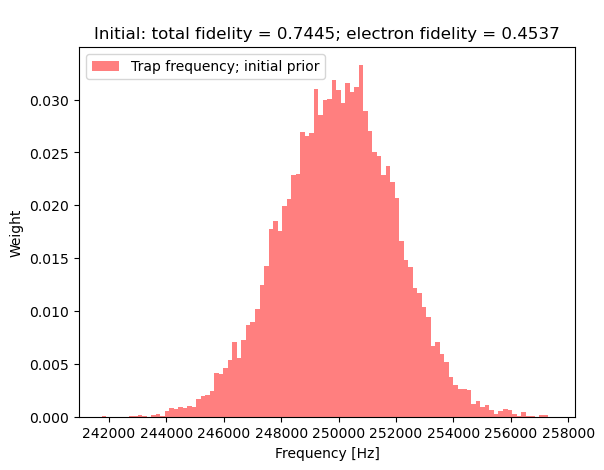

In [1664]:
Random.seed!(1)

# Reinitialize the prior
weights_ν = deepcopy(weights_ν_initial);
particles_ν = deepcopy(particles_ν_initial);

# Initial theta
# ν_INITIAL = μ_ν + 3*σ_ν
ν_INITIAL = 1.01*μ_ν 
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    ν_INITIAL,
    μ_I,
    C0/μ_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], μ_ϕ)
phase!(MS_CHAMBER_UNTUNED.lasers[2], μ_ϕ)

# Remember, the detuning is based on the target trap-frequency, not the true trap-frequency
MS_CHAMBER_UNTUNED.lasers[1].Δ = μ_ν+ DETUNING - AC_CORRECTION
MS_CHAMBER_UNTUNED.lasers[2].Δ = -(μ_ν + DETUNING - AC_CORRECTION)

# Initial belief about theta
ν_bar = sum(particles_ν .* weights_ν)

# Initial fidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = dm(sol[end])
ρ_el = ptrace(ρ, 3)
fid = real(fidelity(ρ, ρ_TARGET))
fid_el = real(fidelity(ρ_el, ρ_00_m_i11))

particles_ν_binned_initial, weights_ν_binned_initial, binwidth_ν_initial = bin_prior(particles_ν_initial, weights_ν_initial, 100)
fig = plt.figure()
plt.bar(particles_ν_binned_initial, weights_ν_binned_initial, width = binwidth_ν_initial, color="r", label = "Trap frequency; initial prior", alpha=0.5)
plt.title("\nInitial: total fidelity = $(round(fid, digits=4)); electron fidelity = $(round(fid_el, digits=4))")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)

## 4.b. Calibrate

In [1665]:
MS_CHAMBER_ν_TUNED, particles_ν, weights_ν, ν_tracker, ν_bar_tracker, ν_fid_tracker, ν_fid_el_tracker, ν_ee_tracker = BayesianCalibration1D(MS_CHAMBER_UNTUNED, particles_ν, weights_ν, p_m_given_ν, "ν", 2, 0.2)
length(ν_tracker)

21

## 4.c. Analyze results

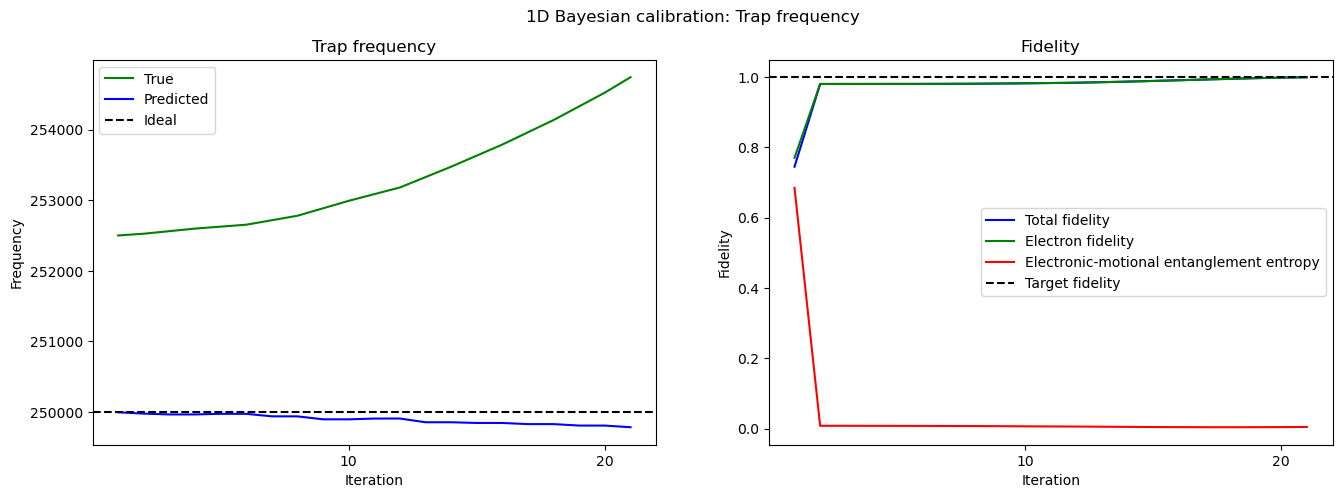

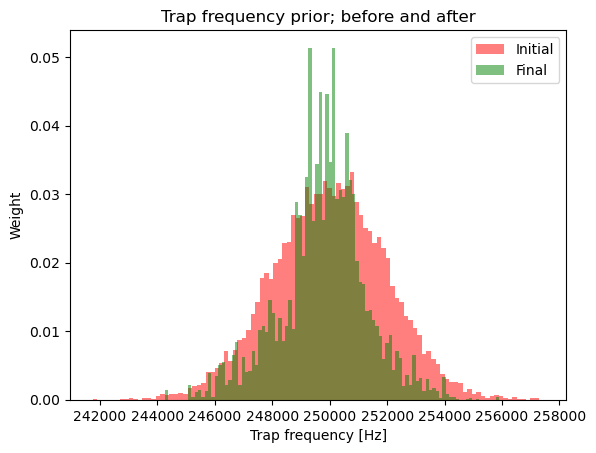

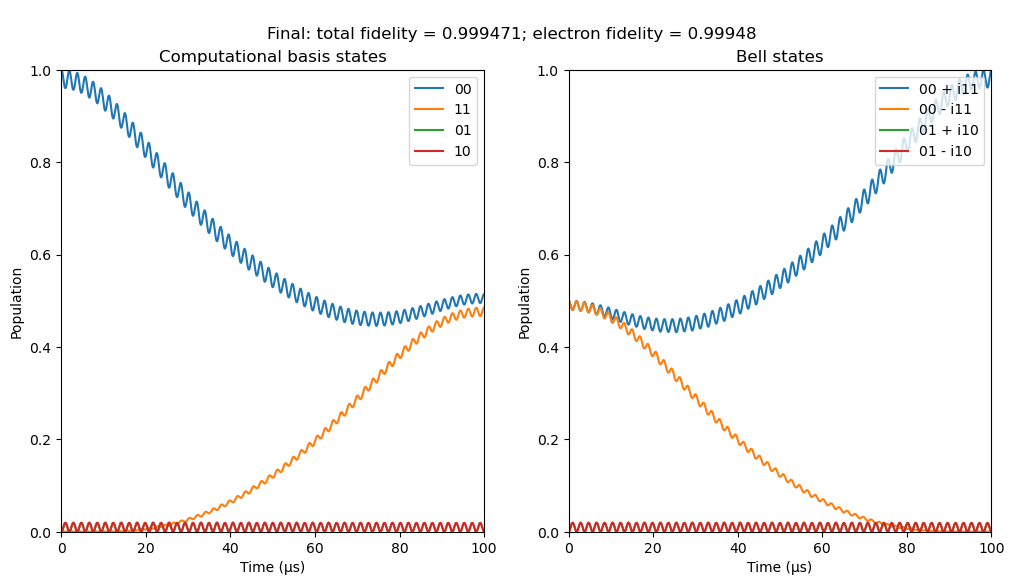

In [1666]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(1:length(ν_tracker), ν_tracker, color="g", label = "True")
ax1.plot(1:length(ν_bar_tracker), ν_bar_tracker, color="b", label = "Predicted")
ax1.axhline(μ_ν, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=[i for i in 1:length(ν_fid_tracker) if i%10==0])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Frequency")
ax1.set_title("Trap frequency")
ax1.legend()
ax2.plot(1:length(ν_fid_tracker), ν_fid_tracker, color="b", label="Total fidelity")
ax2.plot(1:length(ν_fid_el_tracker), ν_fid_el_tracker, color="g", label="Electron fidelity")
ax2.plot(1:length(ν_ee_tracker), ν_ee_tracker, color="r", label = "Electronic-motional entanglement entropy")
ax2.axhline(FID_THRESH, label = "Target fidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=[i for i in 1:length(ν_fid_tracker) if i%10==0])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Fidelity")
ax2.set_title("Fidelity")
ax2.legend()
fig.suptitle("1D Bayesian calibration: Trap frequency")
plt.display(fig)
plt.close(fig)

particles_ν_binned_final, weights_ν_binned_final, binwidth_ν_final = bin_prior(particles_ν, weights_ν, 100)
fig = plt.figure()
plt.bar(particles_ν_binned_initial, weights_ν_binned_initial, width = binwidth_ν_initial, color="r", label = "Initial", alpha=0.5)
plt.bar(particles_ν_binned_final, weights_ν_binned_final, width = binwidth_ν_final, color="g", label = "Final", alpha=0.5)
plt.title("Trap frequency prior; before and after")
plt.xlabel("Trap frequency [Hz]")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)

h = hamiltonian(MS_CHAMBER_ν_TUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = dm(sol[end])
ρ_el = ptrace(ρ, 3)
fid = real(fidelity(ρ, ρ_TARGET))
fid_el = real(fidelity(ρ_el, ρ_00_p_i11))
fig = plot_populations_double(MS_CHAMBER_ν_TUNED, tout, sol)
plt.suptitle("\nFinal: total fidelity = $(round(fid, digits=6)); electron fidelity = $(round(fid_el, digits=6))")
plt.display(fig)
plt.close(fig)

**TODO:** This is weird. Why does fidelity decrease as trap-frequency strays from the "ideal"?

Interesting that it sometimes develops these sidebands. Sara says this might be due to AC stark shift. 

# 5. Calibrating: Phase

## 5.a. Initialize in uncalibrated state

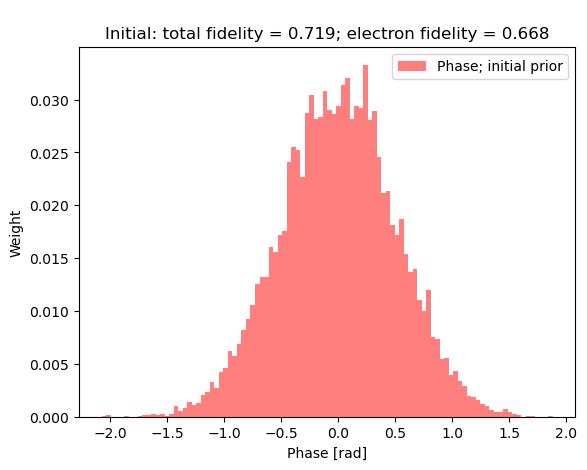

In [1667]:
Random.seed!(1)

weights_ϕ = deepcopy(weights_ϕ_initial);
particles_ϕ = deepcopy(particles_ϕ_initial);

# Initial theta
ϕ_INITIAL = μ_ϕ + 3*σ_ϕ
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    μ_ν,
    μ_I,
    C0/μ_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], 0)
phase!(MS_CHAMBER_UNTUNED.lasers[2], ϕ_INITIAL)

# Initial belief about theta
ϕ_bar = sum(particles_ϕ .* weights_ϕ)

# Initial fidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = dm(sol[end])
ρ_el = ptrace(ρ, 3)
fid = real(fidelity(ρ, ρ_TARGET))
fid_el = real(fidelity(ρ_el, ρ_00_m_i11))

particles_ϕ_binned_initial, weights_ϕ_binned_initial, binwidth_ϕ_initial = bin_prior(particles_ϕ_initial, weights_ϕ_initial, 100)
fig = plt.figure()
plt.bar(particles_ϕ_binned_initial, weights_ϕ_binned_initial, width = binwidth_ϕ_initial, color="r", label = "Phase; initial prior", alpha=0.5)
plt.title("\nInitial: total fidelity = $(round(fid, digits=4)); electron fidelity = $(round(fid_el, digits=4))")
plt.xlabel("Phase [rad]")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)

## 5.b. Calibrate

In [1668]:
MS_CHAMBER_ϕ_TUNED, particles_ϕ, weights_ϕ, ϕ_tracker, ϕ_bar_tracker, ϕ_fid_tracker, ϕ_fid_el_tracker, ϕ_ee_tracker = BayesianCalibration1D(MS_CHAMBER_UNTUNED, particles_ϕ, weights_ϕ, p_m_given_ϕ, "ϕ", 5, 0.1)
length(ϕ_tracker)

100

## 5.c. Analyze results

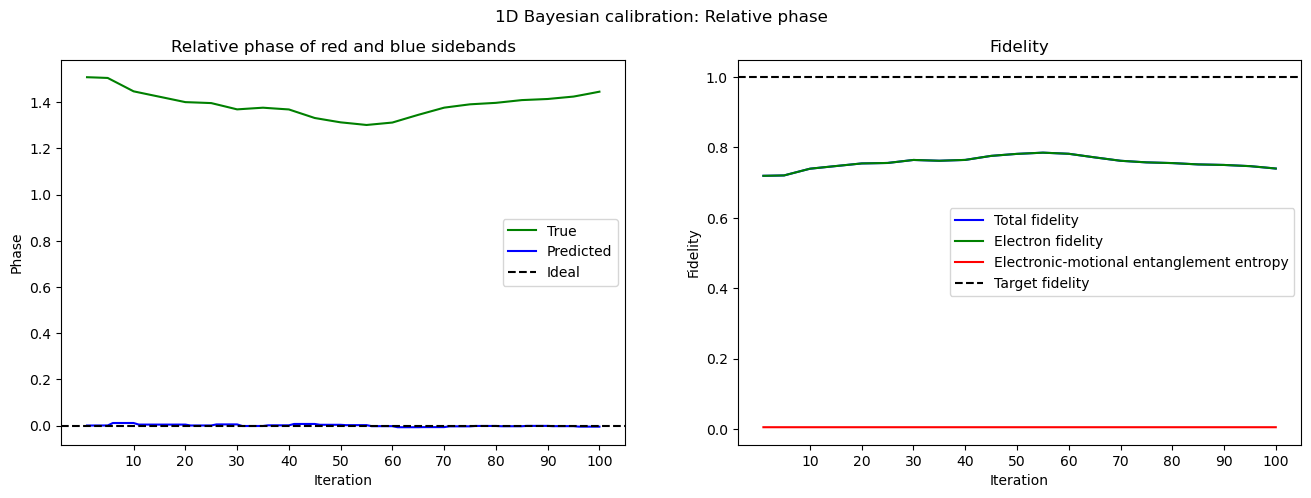

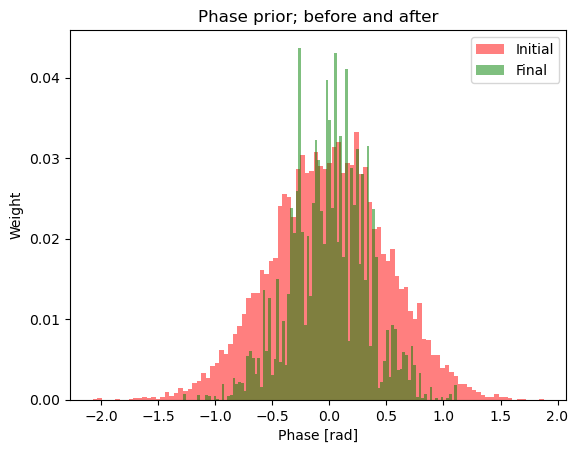

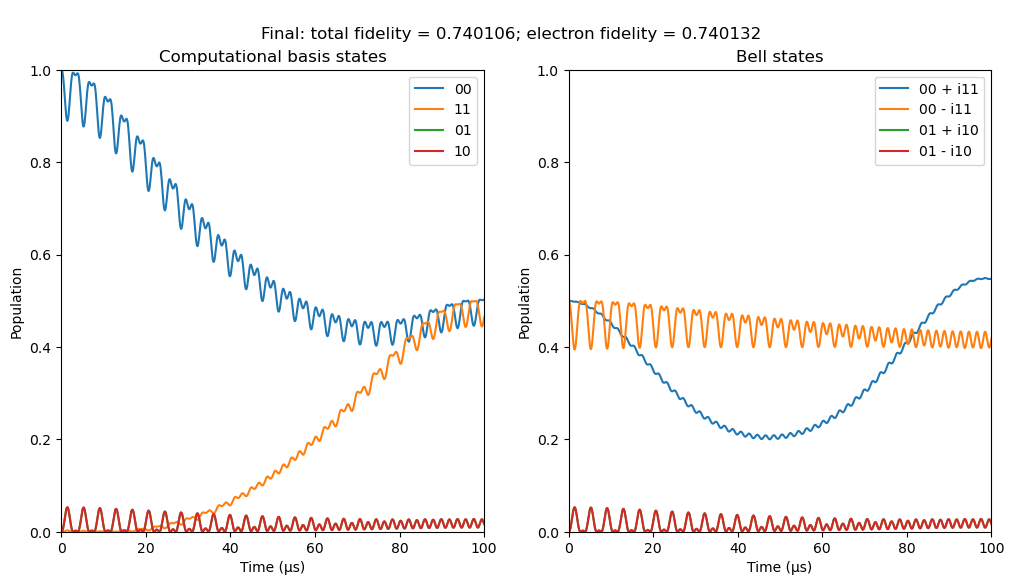

In [1669]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(1:length(ϕ_tracker), ϕ_tracker, color="g", label = "True")
ax1.plot(1:length(ϕ_bar_tracker), ϕ_bar_tracker, color="b", label = "Predicted")
ax1.axhline(μ_ϕ, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=[i for i in 1:length(ϕ_tracker) if i%10==0])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Phase")
ax1.set_title("Relative phase of red and blue sidebands")
ax1.legend()
ax2.plot(1:length(ϕ_fid_tracker), ϕ_fid_tracker, color="b", label="Total fidelity")
ax2.plot(1:length(ϕ_fid_el_tracker), ϕ_fid_el_tracker, color="g", label="Electron fidelity")
ax2.plot(1:length(ϕ_ee_tracker), ϕ_ee_tracker, color="r", label = "Electronic-motional entanglement entropy")
ax2.axhline(FID_THRESH, label = "Target fidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=[i for i in 1:length(ϕ_fid_tracker) if i%10==0])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Fidelity")
ax2.set_title("Fidelity")
ax2.legend()
fig.suptitle("1D Bayesian calibration: Relative phase")
plt.display(fig)
plt.close(fig)

particles_ϕ_binned_final, weights_ϕ_binned_final, binwidth_ϕ_final = bin_prior(particles_ϕ, weights_ϕ, 100)
fig = plt.figure()
plt.bar(particles_ϕ_binned_initial, weights_ϕ_binned_initial, width = binwidth_ϕ_initial, color="r", label = "Initial", alpha=0.5)
plt.bar(particles_ϕ_binned_final, weights_ϕ_binned_final, width = binwidth_ϕ_final, color="g", label = "Final", alpha=0.5)
plt.title("Phase prior; before and after")
plt.xlabel("Phase [rad]")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)

h = hamiltonian(MS_CHAMBER_ϕ_TUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = dm(sol[end])
fid = real(fidelity(ρ, ρ_TARGET))
ρ_el = ptrace(ρ, 3)
fid_el = real(fidelity(ρ_el, ρ_00_p_i11))
fig = plot_populations_double(MS_CHAMBER_ϕ_TUNED, tout, sol)
plt.suptitle("\nFinal: total fidelity = $(round(fid, digits=6)); electron fidelity = $(round(fid_el, digits=6))")
plt.display(fig)
plt.close(fig)